In [2]:
import pandas as pd
import numpy as np
import re

from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

## 导入数据

In [3]:
df_area = pd.read_csv("C:/Users/Genius/Desktop/泰迪杯/全部数据/附件1-区域15分钟负荷数据.csv")
df_area.head()

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Genius/Desktop/泰迪杯/全部数据/附件1-区域15分钟负荷数据.csv'

In [ ]:
df_job = pd.read_csv("C:/Users/Genius/Desktop/泰迪杯/全部数据/附件2-行业日负荷数据.csv")
df_job.head()

,行业类型,数据时间,有功功率最大值（kw）,有功功率最小值（kw）
0,大工业用电,2019/1/1,117888.3300,51526.5690
1,大工业用电,2019/1/2,126843.7914,63638.4294
2,大工业用电,2019/1/3,130286.1294,102048.2754
3,大工业用电,2019/1/4,133018.6344,104466.0762
4,大工业用电,2019/1/5,133504.4784,99507.3528


In [ ]:
df_weather = pd.read_csv("C:/Users/Genius/Desktop/泰迪杯/全部数据/附件3-气象数据.csv")
df_weather.head()

,日期,天气状况,最高温度,最低温度,白天风力风向,夜晚风力风向
0,2018年1月1日,多云/多云,22℃,12℃,无持续风向<3级,无持续风向<3级
1,2018年1月1日,多云/多云,22℃,12℃,无持续风向<3级,无持续风向<3级
2,2018年1月2日,多云/多云,22℃,15℃,无持续风向<3级,无持续风向<3级
3,2018年1月3日,多云/阴,23℃,15℃,无持续风向<3级,无持续风向<3级
4,2018年1月4日,多云/小雨,21℃,16℃,无持续风向<3级,无持续风向<3级


## 观测数据

### 查看缺失值

In [ ]:
df_area.isnull().any()

数据时间         False
总有功功率（kw）    False
dtype: bool

In [ ]:
df_area.shape

(128156, 2)

In [ ]:
df_job.isnull().any()

行业类型           False
数据时间           False
有功功率最大值（kw）    False
有功功率最小值（kw）    False
dtype: bool

In [ ]:
df_job.shape

(3610, 4)

In [ ]:
df_weather.isnull().any()

日期        False
天气状况      False
最高温度      False
最低温度      False
白天风力风向    False
夜晚风力风向    False
dtype: bool

In [ ]:
df_weather.shape

(1345, 6)

## 数据预处理

### 区域15分钟符合数据

In [ ]:
df_area['数据时间'] = pd.to_datetime(df_area['数据时间'], format="%Y-%m-%d %H:%M:%S")
df_area.index = df_area.数据时间
df_area.drop(columns=['数据时间'], axis=1, inplace=True)
df_area.head()

,总有功功率（kw）
数据时间,
2018-01-01 00:00:00,244033.7682
2018-01-01 00:15:00,232720.6402
2018-01-01 00:30:00,231685.6891
2018-01-01 00:45:00,227581.3317
2018-01-01 01:00:00,233482.4269


In [ ]:
val_area = df_area.values

### 气象数据

In [ ]:
# 更改日期显示格式
date = pd.to_datetime(df_weather.loc[:, '日期'], format='%Y年%m月%d日', errors='coerce').apply(lambda x:x.date())
df_weather['日期'] =date

In [ ]:
df_weather['日'] = date.apply(lambda x:x.day)
df_weather['月'] = date.apply(lambda x:x.month)
df_weather['年'] = date.apply(lambda x:x.year)

In [ ]:
# df_weather

In [ ]:
climate = df_weather["天气状况"]
climate
# 白天天气/夜晚天气

0         多云/多云
1         多云/多云
2         多云/多云
3          多云/阴
4         多云/小雨
         ...   
1340    雷阵雨/雷阵雨
1341     雷阵雨/多云
1342    雷阵雨/雷阵雨
1343      阵雨/阵雨
1344     雷阵雨/阵雨
Name: 天气状况, Length: 1345, dtype: object

In [ ]:
climate_day = climate.apply(lambda x:x.split("/")[0])
climate_night = climate.apply(lambda x:x.split("/")[1])

In [ ]:
climate_day.unique()

array(['多云', '阴', '小雨-中雨', '大雨', '中雨', '小雨', '晴', '雷阵雨', '雾', '阵雨',
       '中雨-大雨', '晴间多云', '暴雨', '小到中雨', '中到大雨', '大到暴雨'], dtype=object)

In [ ]:
climate_night.unique()

array(['多云', '阴', '小雨', '中雨-大雨', '中雨', '小雨-中雨', '晴', '局部多云', '阵雨', '雾',
       '雷阵雨', '大雨', '暴雨', '中到大雨', '小到中雨', '大到暴雨'], dtype=object)

In [ ]:
climate_dic = { '晴':0,'晴间多云':0.5,'多云':1, '局部多云':1.5,'阴':2, '雾':2.5,
       '小雨':3, '小雨-中雨':3.5,'小到中雨':4,'中雨':4.5,'阵雨':5,'中雨-大雨':5.5,
       '中到大雨':6, '雷阵雨':6.5, '大雨':7, '大到暴雨':7.5, '暴雨':8, }

In [ ]:
climate_day = climate_day.map(climate_dic)
climate_night = climate_night.map(climate_dic)

In [ ]:
df_weather["最高温度"] = df_weather["最高温度"].apply(lambda x:x.replace("℃",'')).astype(int)
df_weather["最低温度"] = df_weather["最低温度"].apply(lambda x:x.replace("℃",'')).astype(int)

In [ ]:
df_weather["白天天气"] = climate_day 
df_weather["夜晚天气"] = climate_night

In [ ]:
# df_weather.head()

In [ ]:
df_weather['白天风力风向'].apply(lambda x:x.replace("-","～")).unique()

array(['无持续风向<3级', '北风4～5级', '微风<3级', '北风3', '东北风3～4级', '北风3～4级',
       '南风3～4级', '南风4～5级', '东北偏东风2', '无持续风向微风', '无持续风向1～2级', '东风3～4级',
       '东南风4～5级', '东风8～9级', '东南风3～4级', '南风1～2级', '东南风1～2级', '西南风3～4级',
       '东风1～2级', '北风1～2级', '东北风1～2级', '西南风1～2级'], dtype=object)

In [ ]:
df_weather['夜晚风力风向'].apply(lambda x:x.replace("～","-")).unique()

array(['无持续风向<3级', '北风4-5级', '北风3-4级', '微风<3级', '北风3', '东北偏东风2',
       '无持续风向微风', '无持续风向1-2级', '东风3-4级', '东南风4-5级', '东南风3-4级', '东北风3-4级',
       '东风8-9级', '南风3-4级', '南风1-2级', '东南风1-2级', '西南风3-4级', '东风1-2级',
       '北风1-2级', '东北风1-2级', '西南风1-2级'], dtype=object)

In [ ]:
def direct(x):
    dirct = re.match('.*(["东","南","西","北","东南","东北","西南","西北"])',x)
    if(dirct):
        return 2
    else :
        return 1

In [ ]:
df_weather['夜晚风力风向'].apply(lambda x:direct(x))

0       1
1       1
2       1
3       1
4       1
       ..
1340    2
1341    2
1342    2
1343    2
1344    2
Name: 夜晚风力风向, Length: 1345, dtype: int64

In [ ]:
WindPower_dic = {"1-2级":1.5,'2':2,"3":3,"风":1,"3级":3,"3-4级":3.5,"3～4级":3.5,"4-5级":4.5,"8-9级":8.5} 

In [ ]:
df_weather['夜晚风力风向'].apply(lambda x:re.match("\D*(.+)级{0,}",x).group(1)).map(WindPower_dic)

0       3.0
1       3.0
2       3.0
3       3.0
4       3.0
       ... 
1340    1.5
1341    1.5
1342    1.5
1343    1.5
1344    1.5
Name: 夜晚风力风向, Length: 1345, dtype: float64

In [ ]:
direction = df_weather['夜晚风力风向'].apply(lambda x:direct(x)) + df_weather['白天风力风向'].apply(lambda x:direct(x))
df_weather['风向'] = direction

In [ ]:
df_weather['风力'] = df_weather['白天风力风向'].apply(lambda x:re.match("\D*(.+)级{0,}",x).group(1)).map(WindPower_dic) + \
  df_weather['夜晚风力风向'].apply(lambda x:re.match("\D*(.+)级{0,}",x).group(1)).map(WindPower_dic)

In [ ]:
strength = df_weather['白天风力风向'].apply(lambda x:re.match("\D*(.+)级{0,}",x).group(1)).map(WindPower_dic) + \
  df_weather['夜晚风力风向'].apply(lambda x:re.match("\D*(.+)级{0,}",x).group(1)).map(WindPower_dic)

In [ ]:
wind = direction * strength

In [ ]:
df_weather

,日期,天气状况,最高温度,最低温度,白天风力风向,夜晚风力风向,日,月,年,白天天气,夜晚天气,风向,风力
0,2018-01-01,多云/多云,22,12,无持续风向<3级,无持续风向<3级,1,1,2018,1.0,1.0,2,6.0
1,2018-01-01,多云/多云,22,12,无持续风向<3级,无持续风向<3级,1,1,2018,1.0,1.0,2,6.0
2,2018-01-02,多云/多云,22,15,无持续风向<3级,无持续风向<3级,2,1,2018,1.0,1.0,2,6.0
3,2018-01-03,多云/阴,23,15,无持续风向<3级,无持续风向<3级,3,1,2018,1.0,2.0,2,6.0
4,2018-01-04,多云/小雨,21,16,无持续风向<3级,无持续风向<3级,4,1,2018,1.0,3.0,2,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1340,2021-08-27,雷阵雨/雷阵雨,35,26,北风1-2级,北风1-2级,27,8,2021,6.5,6.5,4,3.0
1341,2021-08-28,雷阵雨/多云,33,26,北风1-2级,北风1-2级,28,8,2021,6.5,1.0,4,3.0
1342,2021-08-29,雷阵雨/雷阵雨,32,25,北风1-2级,北风1-2级,29,8,2021,6.5,6.5,4,3.0
1343,2021-08-30,阵雨/阵雨,34,26,北风1-2级,北风1-2级,30,8,2021,5.0,5.0,4,3.0


In [ ]:
df_weather_new = df_weather[['日期', '日', '月', '年','最高温度', '最低温度', '白天天气', '夜晚天气', '风向', '风力']]
df_weather_new.head()

,日期,日,月,年,最高温度,最低温度,白天天气,夜晚天气,风向,风力
0,2018-01-01,1,1,2018,22,12,1.0,1.0,2,6.0
1,2018-01-01,1,1,2018,22,12,1.0,1.0,2,6.0
2,2018-01-02,2,1,2018,22,15,1.0,1.0,2,6.0
3,2018-01-03,3,1,2018,23,15,1.0,2.0,2,6.0
4,2018-01-04,4,1,2018,21,16,1.0,3.0,2,6.0


### 行业日负荷数据

## 区域10天间隔15分钟负荷数据（单变量预测）

### 归一化

In [ ]:
# 归一化
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
val_area = sc.fit_transform(val_area)

In [ ]:
# 准备X和y数据，先用最近一天的23：45这个时刻的功率最为第一个y，然后这个时刻的前 96个时刻的功率作为X
# 这样依次往前推，依次往前准备出大量的 X 和 y，用于后面的训练。
X = []
y = []
for i in range(96, len(val_area)):
    X.append(val_area[i-96:i])
    y.append(val_area[i, val_area.shape[1] - 1])
# X, y = np.array, np.array(y)

In [ ]:
# len(X)

In [ ]:
X_train, y_train= np.array(X[0:100000]), np.array(y[0:100000])
X_test, y_test= np.array(X[100000:len(X)]), np.array(y[100000:len(X)])

In [ ]:
print(f'X_train:{X_train.shape}')
print(f'y_train:{y_train.shape}')
print(f'X_test:{X_test.shape}')
print(f'y_test:{y_test.shape}')

X_train:(100000, 96, 1)
y_train:(100000,)
X_test:(28060, 96, 1)
y_test:(28060,)


In [ ]:
y_test

array([0.5947847 , 0.59642321, 0.59939917, ..., 0.5373049 , 0.53663083,
       0.53285793])

### 构建模型

In [ ]:
import tensorflow as tf
from tensorflow import keras

#这里是使用 Keras，Keras 大大简化了模型创建工作，背后的真正算法实现是用 TensorFlow 或其他。
import tensorflow as tf
from tensorflow import keras

# 设置gpu内存自增长
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# 导入模型
model = tf.keras.models.load_model('./model/1-（1）')

In [ ]:
# 模型构建
# model = tf.keras.Sequential(
#     [tf.keras.layers.LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])),
#      tf.keras.layers.Dropout(0.2),     
     
#      tf.keras.layers.LSTM(units = 32),
#      tf.keras.layers.Dropout(0.2),
     
#      tf.keras.layers.Dense(1)]
# )

In [ ]:
# 模型编译
# model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
model.summary()#显示模型概况参数

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 96, 64)            16896     
_________________________________________________________________
dropout (Dropout)            (None, 96, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# # 召回函数
# callbacks=[
#     keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3)
# ]

In [ ]:
# 模型训练
# model.fit(X_train, y_train, epochs = 100, batch_size = 32, callbacks = callbacks)
# model.fit(X_train, y_train, epochs = 100, batch_size = 32)

In [ ]:
# # 保存模型
# path_save_model = './model/1-（1）'
# model.save(path_save_model, overwrite=True)

### 模型评估

In [ ]:
pred_y = model.predict(X_test)

In [ ]:
predy_scale = sc.inverse_transform(pred_y)

In [ ]:
predy_scale = pd.DataFrame(predy_scale)

In [ ]:
# predy_scale

In [ ]:
df_temp1 = pd.read_csv("C:/Users/Genius/Desktop/泰迪杯/全部数据/附件1-区域15分钟负荷数据.csv")
# df_temp1

In [ ]:
df_temp2 = df_temp1[100096:len(df_temp1)].reset_index(drop = True)

In [ ]:
# df_temp2

In [ ]:
acc = pd.merge(df_temp2, predy_scale, left_index=True, right_index=True)

In [ ]:
acc.columns = ['数据时间', '总有功功率（kw）', 'pred']
# acc

In [ ]:
acc.index = acc.数据时间
acc.drop(columns=['数据时间'], axis=1, inplace=True)
acc.head()

,总有功功率（kw）,pred
数据时间,,
2020/11/9 13:15,221167.7037,218056.265625
2020/11/9 13:30,221767.8970,220707.734375
2020/11/9 13:45,222858.0084,222412.984375
2020/11/9 14:00,241465.0004,238806.453125
2020/11/9 14:15,226178.3272,224440.312500


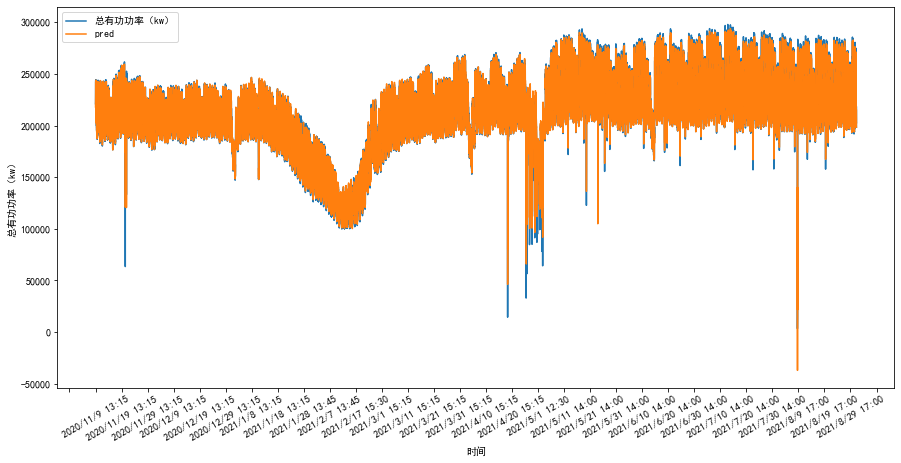

In [ ]:
plt.figure(figsize = (15,7))
plt.plot(acc)
plt.xticks(rotation = 30)

x_major_locator = ticker.MultipleLocator(960)
ax = plt.gca()
ax.xaxis.set_major_locator(x_major_locator)

plt.xlabel('时间')
plt.ylabel('总有功功率（kw）')
plt.legend(labels = ['总有功功率（kw）', 'pred'])
plt.show()

In [ ]:
r2_score(y_test, pred_y)

0.975136945924691

In [ ]:
model.evaluate(X_test, y_test)

877/877 [==============================] - 11s 11ms/step - loss: 2.1762e-04


0.00021761510288342834

### 模型预测

In [ ]:
# df_area[-1:]

In [ ]:
# 模型预测
pre10_single = df_area[-1:]
temp10 = []
df_total = df_area.copy()

for i in range(960):
    # 取最后一个数据
    df_test = pre10_single

    # 然后把测试数据和前面的训练数据整合到一起
    df_total = pd.concat((df_test[['总有功功率（kw）']], df_total[['总有功功率（kw）']]), axis = 0)
#     print(df_total)

    #也是只取具体数值，去掉表头等信息
    inputs = df_total[len(df_total) - i - len(df_test) - 960:].values
    inputs = inputs.reshape(-1, df_test.shape[1])

    #对数据也要做一次规则化处理
    inputs = sc.transform(inputs)
  
    X_test = []
    for j in range(960, 960 + len(df_test)):
        X_test.append(inputs[j-960:j])
    
    X_test = np.array(X_test)
    #对预测数据也做一次数组变形处理
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], df_test.shape[1]))
    
    pre10_single = model.predict(X_test)
    
    pre10_single = sc.inverse_transform(pre10_single)

    pre10_single = pd.DataFrame(pre10_single)
    pre10_single.columns = ['总有功功率（kw）']
    
    temp10.append(pre10_single)  
    
result10_single = temp10

### 预测结果

In [ ]:
Future10_Time = pd.read_excel('./Future10_TIME.xlsx')
# Future10_Time

In [ ]:
temp10 = pd.DataFrame(np.row_stack(temp10))
# temp10

In [ ]:
result10_single = pd.merge(Future10_Time, temp10, left_index=True, right_index=True)
result10_single.columns = ['数据时间', '总有功功率（kw）']
result10_single.head()

,数据时间,总有功功率（kw）
0,2021-09-01 00:00:00,198428.671875
1,2021-09-01 00:15:00,199080.171875
2,2021-09-01 00:30:00,200274.953125
3,2021-09-01 00:45:00,215537.312500
4,2021-09-01 01:00:00,201641.140625


In [ ]:
# 保存结果
tmp_file_path='./结果/result10_single.xlsx'
result10_single.to_excel(tmp_file_path, sheet_name=tmp_file_path.split('.')[0], index= False)

In [ ]:
result10_single.index = result10_single.数据时间
result10_single.drop(columns=['数据时间'], axis=1, inplace=True)
result10_single.head()

,总有功功率（kw）
数据时间,
2021-09-01 00:00:00,198428.671875
2021-09-01 00:15:00,199080.171875
2021-09-01 00:30:00,200274.953125
2021-09-01 00:45:00,215537.312500
2021-09-01 01:00:00,201641.140625


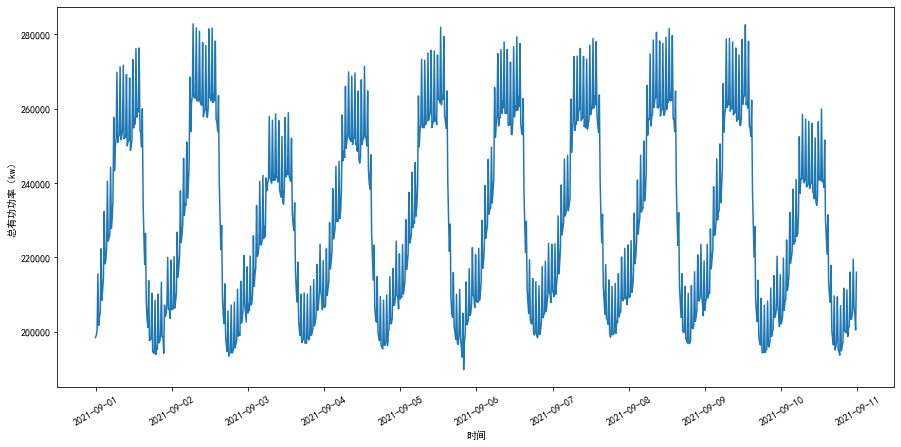

In [ ]:
plt.figure(figsize = (15,7))
plt.plot(result10_single)
plt.xlabel('时间')
plt.ylabel('总有功功率（kw）')
plt.xticks(rotation = 30)
plt.show()

## 三个月最值预测（单变量）

### 模型预测

In [ ]:
# 模型预测
pre90_single = df_area[-1:]
temp90 = []
df_total = df_area.copy()

for i in range(8736):
    # 取最后一个数据
    df_test = pre90_single

    # 然后把测试数据和前面的训练数据整合到一起
    df_total = pd.concat((df_test[['总有功功率（kw）']], df_total[['总有功功率（kw）']]), axis = 0)
#     print(df_total)

    #也是只取具体数值，去掉表头等信息
    inputs = df_total[len(df_total) - i - len(df_test) - 960:].values
    inputs = inputs.reshape(-1, df_test.shape[1])

    #对数据也要做一次规则化处理
    inputs = sc.transform(inputs)
  
    X_test = []
    for j in range(960, 960 + len(df_test)):
        X_test.append(inputs[j-960:j])
    
    X_test = np.array(X_test)
    #对预测数据也做一次数组变形处理
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], df_test.shape[1]))
    
    pre90_single = model.predict(X_test)
    
    pre90_single = sc.inverse_transform(pre90_single)

    pre90_single = pd.DataFrame(pre90_single)
    pre90_single.columns = ['总有功功率（kw）']
    
    temp90.append(pre90_single)  
    
result90_single = temp90

### 预测结果

In [ ]:
Future90_Time = pd.read_excel('./Future90_TIME.xlsx')
Future90_Time

,数据时间
0,2021-09-01 00:00:00
1,2021-09-01 00:15:00
2,2021-09-01 00:30:00
3,2021-09-01 00:45:00
4,2021-09-01 01:00:00
...,...
8731,2021-11-30 22:45:00
8732,2021-11-30 23:00:00
8733,2021-11-30 23:15:00
8734,2021-11-30 23:30:00


In [ ]:
temp90_df = pd.DataFrame(np.row_stack(temp90))
temp90_df

,0
0,198428.671875
1,199080.171875
2,200274.953125
3,215537.312500
4,201641.140625
...,...
8731,228853.125000
8732,216561.500000
8733,217190.203125
8734,216485.765625


In [ ]:
result90_single = pd.merge(Future90_Time, temp90_df, left_index=True, right_index=True)
result90_single.columns = ['数据时间', '总有功功率（kw）']
result90_single.head()

,数据时间,总有功功率（kw）
0,2021-09-01 00:00:00,198428.671875
1,2021-09-01 00:15:00,199080.171875
2,2021-09-01 00:30:00,200274.953125
3,2021-09-01 00:45:00,215537.312500
4,2021-09-01 01:00:00,201641.140625


In [ ]:
# 保存结果
tmp_file_path='./结果/result90_single.xlsx'
result90_single.to_excel(tmp_file_path, sheet_name=tmp_file_path.split('.')[0], index= False)

In [ ]:
temp90_arr = np.array(temp90)
temp90_arr = temp90_arr.reshape(91, 96)
temp90_arr = pd.DataFrame(np.row_stack(temp90_arr))
# type(temp90_arr)

In [ ]:
temp90_arr.columns = pd.date_range('00:00', '23:45', freq = '15min').strftime('%H:%M:%S')

In [ ]:
# temp90_arr

In [ ]:
result90_single_maxmin = pd.DataFrame()
result90_single_maxmin['MAX'] = temp90_arr.max(axis = 1)
result90_single_maxmin['MAX_TIME'] = temp90_arr.idxmax(axis = 1)

result90_single_maxmin['MIN'] = temp90_arr.min(axis = 1)
result90_single_maxmin['MIN_TIME'] = temp90_arr.idxmin(axis = 1)

In [ ]:
# result90_single_maxmin

In [ ]:
Future90_Day = pd.read_excel('./Future90_Day.xlsx')
# Future90_Day

In [ ]:
result90_single_maxmin = pd.merge(Future90_Day, result90_single_maxmin, left_index=True, right_index=True)
# result10_single.columns = ['日期', 'MAX', 'MAX_TIME', 'MIN', 'MIN_TIME']
result90_single_maxmin.head()

,日期,MAX,MAX_TIME,MIN,MIN_TIME
0,2021-9-1,276327.34375,13:45:00,193886.562500,19:00:00
1,2021-9-2,282846.06250,06:45:00,193406.078125,18:00:00
2,2021-9-3,258935.78125,12:45:00,196860.296875,18:30:00
3,2021-9-4,271428.15625,12:45:00,195352.687500,18:30:00
4,2021-9-5,281928.12500,12:45:00,189741.890625,20:00:00


In [ ]:
result90_single_maxmin.index = result90_single_maxmin.日期
result90_single_maxmin.drop(columns=['日期'], axis=1, inplace=True)
result90_single_maxmin.head()

,MAX,MAX_TIME,MIN,MIN_TIME
日期,,,,
2021-9-1,276327.34375,13:45:00,193886.562500,19:00:00
2021-9-2,282846.06250,06:45:00,193406.078125,18:00:00
2021-9-3,258935.78125,12:45:00,196860.296875,18:30:00
2021-9-4,271428.15625,12:45:00,195352.687500,18:30:00
2021-9-5,281928.12500,12:45:00,189741.890625,20:00:00


## 区域10天间隔15分钟负荷数据（多变量预测）

### 合并数据集

In [ ]:
df_area = pd.read_csv("C:/Users/Genius/Desktop/泰迪杯/全部数据/附件1-区域15分钟负荷数据.csv")
# df_area.head()

In [ ]:
df_area.head()

,数据时间,总有功功率（kw）
0,2018/1/1 0:00,244033.7682
1,2018/1/1 0:15,232720.6402
2,2018/1/1 0:30,231685.6891
3,2018/1/1 0:45,227581.3317
4,2018/1/1 1:00,233482.4269


In [ ]:
df_area_new = df_area.copy()
df_area_new['分'] = pd.to_datetime(df_area['数据时间']).apply(lambda x:x.minute)
df_area_new['时'] = pd.to_datetime(df_area['数据时间']).apply(lambda x:x.hour)
df_area_new['日期']=pd.to_datetime(df_area['数据时间']).apply(lambda x:x.date())
df_area_new

,数据时间,总有功功率（kw）,分,时,日期
0,2018/1/1 0:00,244033.7682,0,0,2018-01-01
1,2018/1/1 0:15,232720.6402,15,0,2018-01-01
2,2018/1/1 0:30,231685.6891,30,0,2018-01-01
3,2018/1/1 0:45,227581.3317,45,0,2018-01-01
4,2018/1/1 1:00,233482.4269,0,1,2018-01-01
...,...,...,...,...,...
128151,2021/8/31 22:45,202409.1270,45,22,2021-08-31
128152,2021/8/31 23:00,218576.4635,0,23,2021-08-31
128153,2021/8/31 23:15,200112.5091,15,23,2021-08-31
128154,2021/8/31 23:30,199865.5937,30,23,2021-08-31


In [ ]:
# 联立两个df，去空值、去重
df_15 = pd.merge(df_area_new, df_weather_new, on = '日期',how = 'inner').dropna().drop_duplicates().reset_index(drop=True)

In [ ]:
# df_15

In [ ]:
df_15 = df_15[['日期', '年', '月', '日', '时', '分', '最高温度', '最低温度', '白天天气', '夜晚天气', '风向', '风力', '总有功功率（kw）']]
# df_15

In [ ]:
df_15['日期'] = pd.to_datetime(df_15['日期'], format="%Y-%m-%d %H:%M:%S")
df_15.index = df_15.日期
df_15.drop(columns=['日期'], axis=1, inplace=True)
df_15.head()

,年,月,日,时,分,最高温度,最低温度,白天天气,夜晚天气,风向,风力,总有功功率（kw）
日期,,,,,,,,,,,,
2018-01-01,2018,1,1,0,0,22,12,1.0,1.0,2,6.0,244033.7682
2018-01-01,2018,1,1,0,15,22,12,1.0,1.0,2,6.0,232720.6402
2018-01-01,2018,1,1,0,30,22,12,1.0,1.0,2,6.0,231685.6891
2018-01-01,2018,1,1,0,45,22,12,1.0,1.0,2,6.0,227581.3317
2018-01-01,2018,1,1,1,0,22,12,1.0,1.0,2,6.0,233482.4269


In [ ]:
val_15= df_15.values

### 归一化

In [ ]:
# 归一化
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
val_15 = sc.fit_transform(val_15)

### 切分数据集

In [ ]:
# 准备X和y数据，先用最近一天的23：45这个时刻的功率最为第一个y，然后这个时刻的前 96个时刻的功率作为X
# 这样依次往前推，依次往前准备出大量的 X 和 y，用于后面的训练。
X = []
y = []
for i in range(96*10, len(val_15)):
    X.append(val_15[i-96*10:i])
    y.append(val_15[i, val_area.shape[1] - 1])
# X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train, y_train= np.array(X[0:100000]), np.array(y[0:100000])
X_test, y_test= np.array(X[100000:len(X)]), np.array(y[100000:len(X)])

In [97]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(100000, 96, 12) (100000,) (27676, 96, 12) (27676,)


### 构建模型

In [98]:
# 导入模型
model2 = tf.keras.models.load_model('./model/1-（2）')

In [99]:
# 模型构建
# model2 = tf.keras.Sequential(
#     [tf.keras.layers.LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])),
#      tf.keras.layers.Dropout(0.2),
     
#      tf.keras.layers.LSTM(units = 32),
#      tf.keras.layers.Dropout(0.2),
     
#      tf.keras.layers.Dense(1)]
# )

In [100]:
# 模型编译
# model2.compile(optimizer = 'adam', loss = 'mse')

In [101]:
model2.summary()#显示模型概况参数

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 96, 64)            19712     
_________________________________________________________________
dropout_2 (Dropout)          (None, 96, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 32,161
Trainable params: 32,161
Non-trainable params: 0
_________________________________________________________________


In [102]:
# callbacks=[
#     keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3)
# ]

In [103]:
# 模型训练
# model2.fit(X_train, y_train, epochs = 100, batch_size = 32, callbacks = callbacks)
# model2.fit(X_train, y_train, epochs = 100, batch_size = 32)

In [104]:
# # 保存模型
# path_save_model = './model/1-（2）'
# model2.save(path_save_model, overwrite=True)

### 模型评估

In [105]:
pred_y = model2.predict(X_test)

In [106]:
r2_score(y_test, pred_y)

-5.123289378686803

In [107]:
model2.evaluate(X_test, y_test)

865/865 [==============================] - 11s 11ms/step - loss: 0.0951


0.09512212872505188

### 模型预测